In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pickle

## Load the dataset

In [6]:
df = pd.read_csv('city_aqi_day.csv')

## Convert 'Date' to datetime objects and sort the data

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['City', 'Date'], inplace=True)

## Use interpolation to fill missing values

In [8]:
columns_to_interpolate = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
df[columns_to_interpolate] = df.groupby('City')[columns_to_interpolate].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)
df.dropna(subset=['AQI', 'PM2.5'], inplace=True)

## Function to remove outliers using IQR

In [9]:
def remove_outlier_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

## Remove outliers from key pollutant columns

In [10]:
pollutant_columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
for col in pollutant_columns:
    if col in df.columns:
        df = remove_outlier_iqr(df, col)
print("Data cleaning and preprocessing complete!")

Data cleaning and preprocessing complete!


## Exploratory Data Analysis

### Distribution of AQI

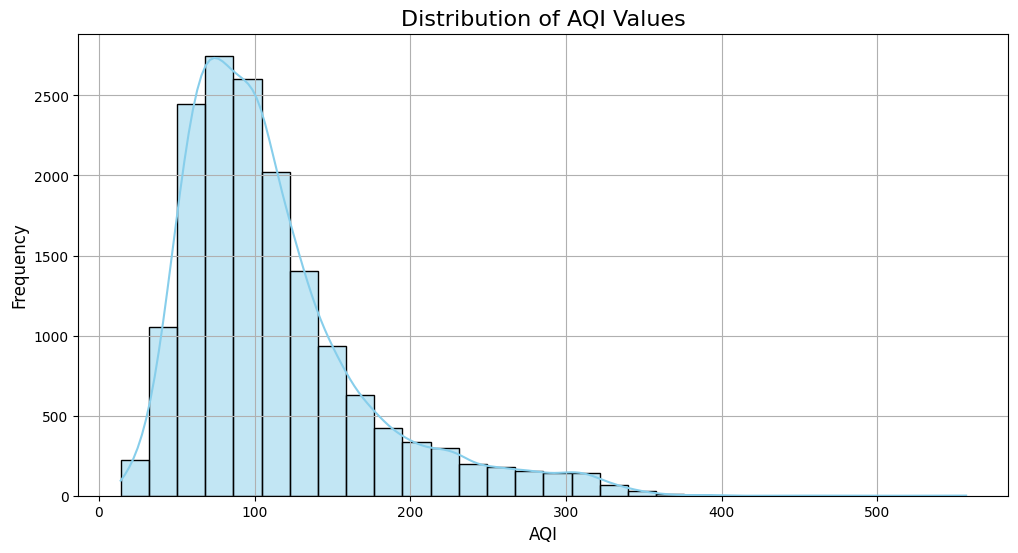

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['AQI'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of AQI Values', fontsize=16)
plt.xlabel('AQI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

### Correlation Heatmap

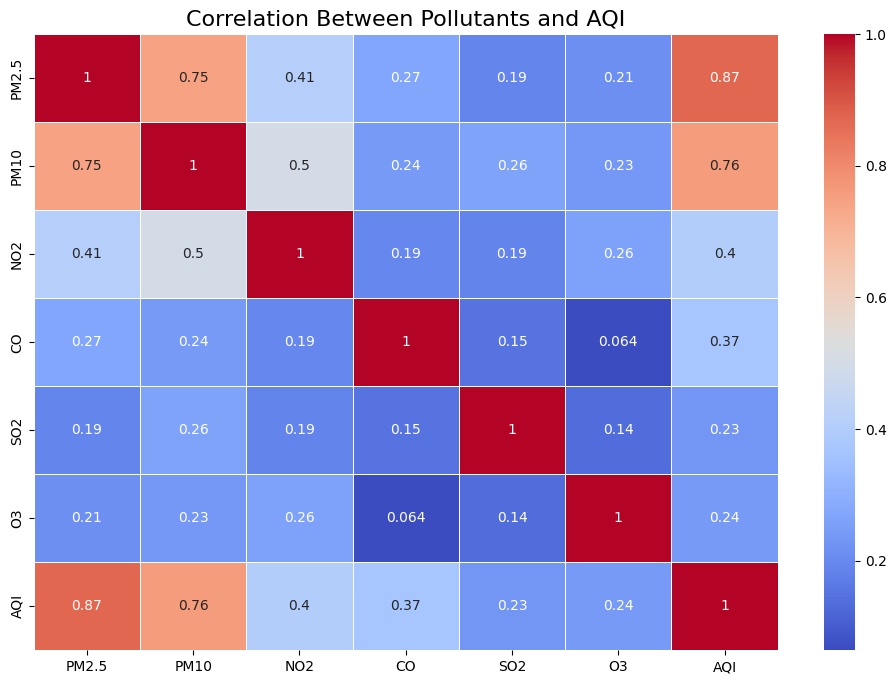

In [12]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Pollutants and AQI', fontsize=16)
plt.show()

## Feature Selection and Splitting Data

In [13]:
X = df[['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']]
y = df['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Model

In [14]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Model training complete!")

Model training complete!


## Evaluate the Model

In [15]:
predictions = model.predict(X_test)
print('\nModel Performance:')
print('R^2 Score:', metrics.r2_score(y_test, predictions))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


Model Performance:
R^2 Score: 0.8316026572594493
MAE: 15.228034267912772
MSE: 619.9841704984424
RMSE: 24.899481329908106


## Visualize the Results

###  Actual vs. Predicted AQI

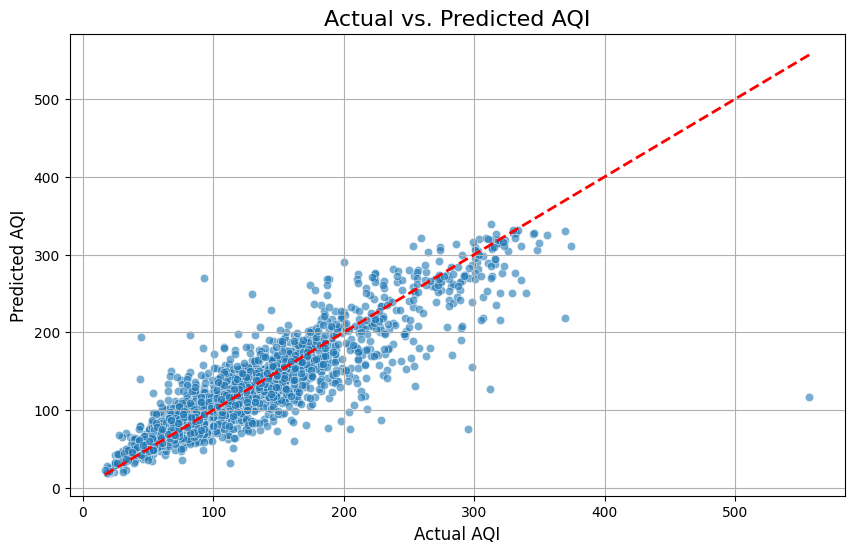

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs. Predicted AQI', fontsize=16)
plt.xlabel('Actual AQI', fontsize=12)
plt.ylabel('Predicted AQI', fontsize=12)
plt.grid(True)
plt.show()

### Feature Importance Plot

C:\Users\verma\AppData\Local\Temp\ipykernel_12532\3434381818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


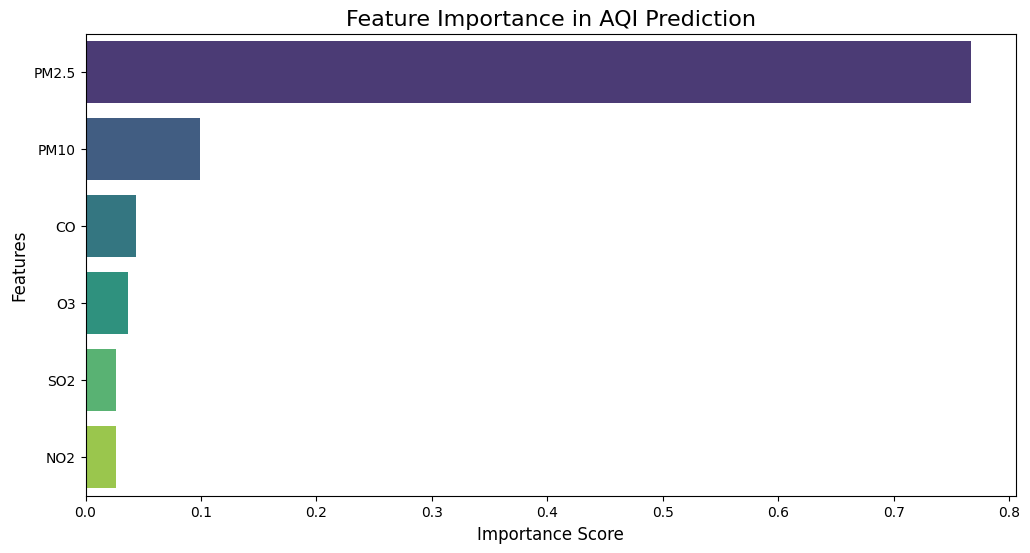

In [17]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
plt.title('Feature Importance in AQI Prediction', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

### Residuals Plot

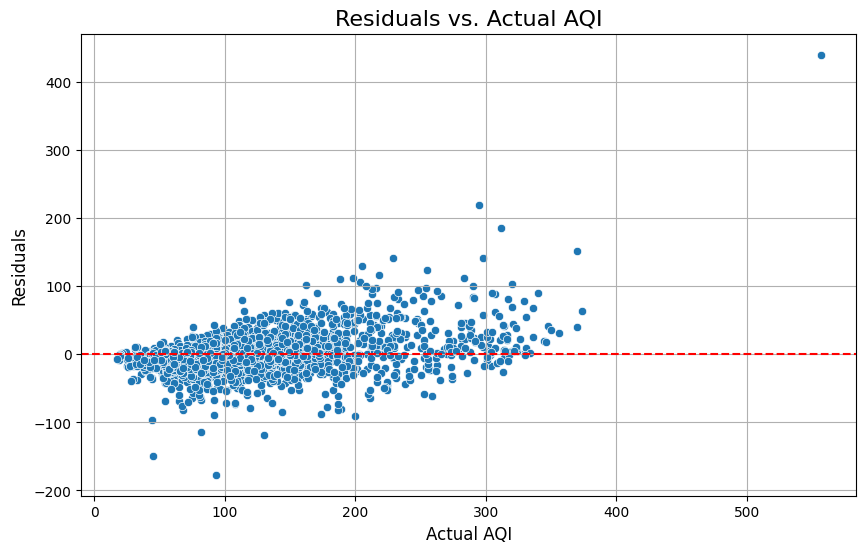

In [18]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Actual AQI', fontsize=16)
plt.xlabel('Actual AQI', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True)
plt.show()

## Save the Mode

In [22]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("\nTrained model saved as model.pkl")


Trained model saved as model.pkl


In [21]:
feature_list = list(X.columns)
with open('features.pkl', 'wb') as file:
    pickle.dump(feature_list, file)
print("Feature list saved as features.pkl")

Feature list saved as features.pkl
